In [7]:
import os
import pandas as pd
import numpy as np
import time

main_publisher = 'MIT'

script_dir = os.path.dirname(os.path.realpath('__file__'))
path = os.path.join(script_dir, '../Data/' + main_publisher + '/')

df_chapters = pd.read_csv(path + 'chapters.csv', delimiter = '|')
df_chapters_embeddings = pd.read_csv(path + 'embeddings_chapters.csv', delimiter = '|', index_col=0)
df_concepts = pd.read_csv(path + 'concepts_bis.csv', delimiter = '|')
df_concepts_embeddings = pd.read_csv(path + 'embeddings_concepts_bis.csv', delimiter = '|', index_col=0)
df_classes = pd.read_csv(path + 'classes.csv', delimiter = '|')
df_classes_embeddings = pd.read_csv(path + 'embeddings_classes_bis.csv', delimiter = '|', index_col=0)
df_precedences_episodes = pd.read_csv(path + 'precedences_episodes.csv', delimiter = '|')
df_precedences_series = pd.read_csv(path + 'precedences_series.csv', delimiter = '|')

df_concepts['Concept'] = df_concepts['Concept'].apply(lambda x : x.split('/')[-1])

df_classes = df_classes.dropna()
print(f'{df_chapters["Cid"].isna().sum().sum():04d} NaN values in chapters.')
print(f'{df_concepts.isna().sum().sum():04d} Nan values in concepts.')
print(f'{df_classes.isna().sum().sum():04d} Nan values in classes.')
print(f'{df_precedences_episodes.isna().sum().sum():04d} Nan values in episdes precedences.')
print(f'{df_precedences_series.isna().sum().sum():04d} Nan values in series precedences.')

0000 NaN values in chapters.
0000 Nan values in concepts.
0000 Nan values in classes.
0000 Nan values in episdes precedences.
0000 Nan values in series precedences.


In [8]:
from utils import *

unique_oer_id = id_mapper(df_chapters['Cid'], 'OER')
unique_concept_id =  id_mapper(df_concepts['Concept'], 'Concept')
unique_class_id =  id_mapper(df_classes['Class'], 'Class')

In [9]:
oer_covers_concept_subject = edge_construction(df1 = df_concepts, df2 = unique_oer_id, col = 'mappedID', 
                                       how = 'left', right_on = 'OER')
oer_covers_concept_pr = edge_construction(df1 = df_concepts, df2 = unique_oer_id, col = 'PR', 
                                          how = 'right', right_on = 'OER')
oer_covers_concept_object = edge_construction(df1 = df_concepts, df2 = unique_concept_id, col = 'mappedID', 
                                       how = 'left', right_on = 'Concept')

oer_before_oer_ep_subject = edge_construction(df1 = df_precedences_episodes, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Before', right_on = 'OER')
oer_before_oer_ep_object = edge_construction(df1 = df_precedences_episodes, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'After', right_on = 'OER')
oer_before_oer_sr_subject = edge_construction(df1 = df_precedences_series, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Before', right_on = 'OER')
oer_before_oer_sr_object = edge_construction(df1 = df_precedences_series, df2 = unique_oer_id, col = 'mappedID', 
                                   how = 'left', left_on = 'After', right_on = 'OER')

concept_belongs_class_subject = edge_construction(df1 = df_classes, df2 = unique_concept_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Concept', right_on = 'Concept')
concept_belongs_class_object = edge_construction(df1 = df_classes, df2 = unique_class_id, col = 'mappedID', 
                                   how = 'left', left_on = 'Class', right_on = 'Class')

oer_covers_concept = torch.stack([oer_covers_concept_subject, oer_covers_concept_object], dim = 0).long()
oer_covers_concept_rev = torch.stack([oer_covers_concept_object, oer_covers_concept_subject], dim = 0).long()
oer_before_oer_ep = torch.stack([oer_before_oer_ep_subject, oer_before_oer_ep_object], dim = 0).long()
oer_before_oer_sr = torch.stack([oer_before_oer_sr_subject, oer_before_oer_sr_object], dim = 0).long()
concept_belongs_class = torch.stack([concept_belongs_class_subject, concept_belongs_class_object], dim = 0).long()
concept_belongs_class_rev = torch.stack([concept_belongs_class_object, concept_belongs_class_subject], dim = 0).long()
print(oer_covers_concept.shape)
print(oer_covers_concept_rev.shape)
print(oer_before_oer_ep.shape)
print(oer_before_oer_sr.shape)
print(concept_belongs_class.shape)
print(concept_belongs_class_rev.shape)

torch.Size([2, 31681])
torch.Size([2, 31681])
torch.Size([2, 830])
torch.Size([2, 988])
torch.Size([2, 14544])
torch.Size([2, 14544])


In [10]:
chapters_embeddings_tmp = {}
concepts_embeddings_tmp = {}
classes_embeddings_tmp = {}

chapters_r = range(len(df_chapters['Cid'].unique()))
concepts_c = range(len(df_concepts['Concept'].unique()))
classes_c = range(len(df_classes['Class'].unique()))

chapters_embeddings = np.zeros(shape=(len(chapters_r), 768))
concepts_embeddings = np.zeros(shape=(len(concepts_c), 768))
classes_embeddings = np.zeros(shape=(len(classes_c), 768))


i = 0
for r in chapters_r:
    chapters_embeddings_tmp[r] = list(filter(None, df_chapters_embeddings['BERT'][r].strip("[]\n").replace("'","").split(" ")))
    chapters_embeddings_tmp[r] = [float(f) for f in chapters_embeddings_tmp[r]]
    for a in range(len(chapters_embeddings_tmp[r])):
            chapters_embeddings[i][a] = chapters_embeddings_tmp[r][a]
    i += 1

i = 0
for r in concepts_c:
    concepts_embeddings_tmp[r] = list(filter(None, df_concepts_embeddings['BERT'][r].strip("[]\n").replace("'","").split(" ")))
    concepts_embeddings_tmp[r] = [float(f) for f in concepts_embeddings_tmp[r]]
    for a in range(len(concepts_embeddings_tmp[r])):
            concepts_embeddings[i][a] = concepts_embeddings_tmp[r][a]
    i += 1   

i = 0
for r in classes_c:
    classes_embeddings_tmp[r] = list(filter(None, df_classes_embeddings['BERT'][r].strip("[]\n").replace("'","").split(" ")))
    classes_embeddings_tmp[r] = [float(f) for f in classes_embeddings_tmp[r]]
    for a in range(len(classes_embeddings_tmp[r])):
            classes_embeddings[i][a] = classes_embeddings_tmp[r][a]
    i += 1

chapters_embeddings = torch.from_numpy(chapters_embeddings).to(torch.float32)
concepts_embeddings = torch.from_numpy(concepts_embeddings).to(torch.float32)
classes_embeddings = torch.from_numpy(classes_embeddings).to(torch.float32)

In [11]:
import random

def seed_everything(seed=0):                                                  
       random.seed(seed)                                                            
       torch.manual_seed(seed)                                                      
       torch.cuda.manual_seed_all(seed)                                             
       np.random.seed(seed)                                                         
       os.environ['PYTHONHASHSEED'] = str(seed)                                     
       torch.backends.cudnn.deterministic = True                                    
       torch.backends.cudnn.benchmark = False

In [12]:
hidden_channels_selected = 16
entity_features = 768
num_layers_selected = 6
epochs_selected = 300 #300 the best
learning_rates_selected = 0.01

selected_params = [{
    'epochs': epochs_selected, 
    'hidden_channels': hidden_channels_selected, 
    'num_layers': num_layers_selected, #8 is too much => generated NaN values in node attributes
    'lr': learning_rates_selected, 
    'entity_features': entity_features
}]

In [51]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()
data['OER'].node_id = torch.tensor(unique_oer_id['mappedID'].values)
data['OER'].x = chapters_embeddings
data['Concept'].node_id = torch.tensor(unique_concept_id['mappedID'].values)
data['Concept'].x = concepts_embeddings
data['OER', 'covers', 'Concept'].edge_index = oer_covers_concept
data['Concept', 'rev_covers', 'OER'].edge_index = oer_covers_concept_rev

data['OER', 'covers', 'Concept'].edge_attr = oer_covers_concept_pr
#print(oer_before_oer_ep.shape)
data['OER', 'before_sr', 'OER'].edge_index = oer_before_oer_sr
data['OER', 'before_ep', 'OER'].edge_index = oer_before_oer_ep

#data = T.ToUndirected()(data)
data.validate()
print(data)

HeteroData(
  OER={
    node_id=[1860],
    x=[1860, 768]
  },
  Concept={
    node_id=[6393],
    x=[6393, 768]
  },
  (OER, covers, Concept)={
    edge_index=[2, 31681],
    edge_attr=[31686]
  },
  (Concept, rev_covers, OER)={ edge_index=[2, 31681] },
  (OER, before_sr, OER)={ edge_index=[2, 988] },
  (OER, before_ep, OER)={ edge_index=[2, 830] }
)


In [52]:
agnostic = False
if agnostic:
    num_val = 0.5
    num_test = 0.5
else:
    num_val = 0.1
    num_test = 0.1
seed_everything()
transform = T.RandomLinkSplit(
    num_val = num_val,
    num_test = num_test,
    disjoint_train_ratio = 0.0,
    neg_sampling_ratio = 0.8,
    add_negative_train_samples = True,
    edge_types=('OER', 'before_sr', 'OER')
)

train_data, val_data, test_data = transform(data)
print(f'{len(train_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for training')
print(f'{len(val_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for validation')
print(f'{len(test_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for testing')
print(train_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(val_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(test_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(train_data["OER", "before_sr", "OER"].edge_label_index[1][:5])
print(val_data["OER", "before_sr", "OER"].edge_label_index[1][:5])
print(test_data["OER", "before_sr", "OER"].edge_label_index[1][:5])

1425	 Edges for training
176	 Edges for validation
176	 Edges for testing
tensor([462, 793, 935, 826, 124])
tensor([1266, 1033,   99,   80, 1692])
tensor([ 904, 1112,  130,  383,   54])
tensor([463, 794, 936, 827, 125])
tensor([1267, 1034,  100,   81, 1693])
tensor([ 905, 1113,  131,  384,   55])


In [53]:
seed_everything()
cross_val_data = {}
cross_val_data["OER", "before_sr", "OER"] = {}
print(len(train_data["OER", "before_sr", "OER"].edge_label_index[0]) + 
      len(val_data["OER", "before_sr", "OER"].edge_label_index[0]) +
      len(test_data["OER", "before_sr", "OER"].edge_label_index[0]))

cross_val_data["OER", "before_sr", "OER"]["edge_label"] = torch.cat(
    [train_data["OER", "before_sr", "OER"].edge_label, 
     val_data["OER", "before_sr", "OER"].edge_label,
     test_data["OER", "before_sr", "OER"].edge_label], 
    dim = 0).long()
cross_val_data["OER", "before_sr", "OER"]["edge_label_index"] = torch.cat(
    [train_data["OER", "before_sr", "OER"].edge_label_index, 
     val_data["OER", "before_sr", "OER"].edge_label_index,
     test_data["OER", "before_sr", "OER"].edge_label_index], 
    dim = 1).long()
cross_val_data["OER", "before_sr", "OER"]["edge_index"] = torch.cat(
    [train_data["OER", "before_sr", "OER"].edge_index, 
     val_data["OER", "before_sr", "OER"].edge_index,
     test_data["OER", "before_sr", "OER"].edge_index],
    dim = 1).long()
print(len(cross_val_data["OER", "before_sr", "OER"]["edge_label"]))
print(len(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0]))
print(len(cross_val_data["OER", "before_sr", "OER"]["edge_index"][0]))

1777
1777
1777
2474


In [54]:
seed_everything()
num_samples = len(cross_val_data["OER", "before_sr", "OER"]["edge_label"])
shuffled_index = np.arange(num_samples)
np.random.shuffle(shuffled_index)
cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0] = cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0][shuffled_index]
cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1] = cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1][shuffled_index]
cross_val_data["OER", "before_sr", "OER"]["edge_label"] = cross_val_data["OER", "before_sr", "OER"]["edge_label"][shuffled_index]

In [55]:
cv = 5
chunk_size = int(len(cross_val_data["OER", "before_sr", "OER"]["edge_label"]) / cv)
cross_val_chunks = []
for n in range(cv):
    cross_val_chunk = {}
    cross_val_chunk["OER", "before_sr", "OER"] = {}
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label"] = {}
    begin = n * chunk_size
    if n == cv - 1:
        end = len(cross_val_data["OER", "before_sr", "OER"]["edge_label"])
    else :
        end = (n+1) * chunk_size
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label"] = cross_val_data["OER", "before_sr", "OER"]["edge_label"][begin : end]
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label_index"] = []
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0][begin : end])
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1][begin : end])
    cross_val_chunks.append(cross_val_chunk)

In [56]:
cross_val_data_train = []
cross_val_data_test = []
for n in range(cv) :
    cross_val_data_train_chunk = {}
    cross_val_data_train_chunk["OER", "before_sr", "OER"] = {}
    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label"] = torch.cat(
    [cross_val_chunks[(n+1)%cv]["OER", "before_sr", "OER"]["edge_label"], 
     cross_val_chunks[(n+2)%cv]["OER", "before_sr", "OER"]["edge_label"],
     cross_val_chunks[(n+3)%cv]["OER", "before_sr", "OER"]["edge_label"],
     cross_val_chunks[(n+4)%cv]["OER", "before_sr", "OER"]["edge_label"]
     ], 
    dim = 0).long()
    cross_val_data_test_chunk = {}
    cross_val_data_test_chunk["OER", "before_sr", "OER"] = {}
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label"] = cross_val_chunks[n]["OER", "before_sr", "OER"]["edge_label"]

    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label_index"] = []
    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(torch.cat(
    [cross_val_chunks[(n+1)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0], 
     cross_val_chunks[(n+2)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0],
     cross_val_chunks[(n+3)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0],
     cross_val_chunks[(n+4)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0]
     ], 
    dim = 0).long())
    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(torch.cat(
    [cross_val_chunks[(n+1)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1], 
     cross_val_chunks[(n+2)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1],
     cross_val_chunks[(n+3)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1],
     cross_val_chunks[(n+4)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1]
     ], 
    dim = 0).long())
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label_index"] = []
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(
        cross_val_chunks[n]["OER", "before_sr", "OER"]["edge_label_index"][0])
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(
        cross_val_chunks[n]["OER", "before_sr", "OER"]["edge_label_index"][1])
    
    cross_val_data_train.append(cross_val_data_train_chunk)
    cross_val_data_test.append(cross_val_data_test_chunk)

len(cross_val_data_train)

5

In [57]:
def train(model, train_data, epochs, lr, verbose = False):
    total_loss = 0
    loss_values = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    train_data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    duration = time.time()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(train_data)
        ground_truth = train_data["OER", "before_sr", "OER"].edge_label
        assert pred.shape == ground_truth.shape, f'ERROR : Shapes differ between prediction and ground truth ! ({pred.shape, ground_truth.shape})'
        loss = F.binary_cross_entropy_with_logits(pred.float(), ground_truth.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss)
        loss_values.append(loss.item())
        if verbose and epoch % 10 == 0:
            print(f"Epoch : {epoch:03d}, Loss : {total_loss : .4f}")
    duration = time.time() - duration
    
    return {
        'Loss_values' : loss_values,
        'Loss' : total_loss,
        'Duration' : duration,
        'Model' : model
    }
def predict(model, test_data):

    preds = model(test_data).detach().numpy()
    preds_labels = (preds > 0.5) * 1
    ground_truths = test_data["OER", "before_sr", "OER"].edge_label
    assert preds.shape == ground_truths.shape, f'ERROR : Shapes differ between prediction and ground truth ! ({preds.shape, ground_truths.shape})'
    #auc_score = roc_auc_score(ground_truths, preds)
    precision = precision_score(ground_truths, preds_labels, zero_division = np.nan)
    accuracy = accuracy_score(ground_truths, preds_labels)
    f1 = f1_score(ground_truths, preds_labels, average='macro')
    recall = recall_score(ground_truths, preds_labels, average='macro')
    return {
        #'AUC' : auc_score,
        'Precision' : precision,
        'Accuracy' : accuracy,
        'Recall' : recall,
        'F1' : f1
    }

In [58]:
from torch_geometric.nn import HeteroConv, GCNConv, GATConv, Linear, SAGEConv
from torch_geometric.data import HeteroData
import torch.nn.functional as F
from torch import Tensor
import numpy as np
import torch
import random
import os
class ModelNoEnrichment(torch.nn.Module):
    def __init__(self, node_types, heads, hidden_channels, out_channels, entity_features, num_layers):
        super().__init__()
        self.gnn = self.HeteroGNN(node_types, heads, hidden_channels, out_channels, num_layers)
        self.gnn = self.gnn.float()
        self.classifier = self.Classifier(hidden_channels + entity_features)

    def forward(self, data : HeteroData) -> Tensor:
        node_dict_emb = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
        }
        node_dict = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
        }
        edge_dict = {
            ("OER", "before_sr", "OER"): data["OER", "before_sr", "OER"].edge_label_index,
            ("OER", "before_ep", "OER"): data["OER", "before_ep", "OER"].edge_index,
            ("OER", "covers", "Concept") : data["OER", "covers", "Concept"].edge_index,
            ("Concept", "rev_covers", "OER") : data["Concept", "rev_covers", "OER"].edge_index
        }

        node_dict_emb = self.gnn(node_dict_emb, edge_dict)
        node_dict = {
            "OER" : torch.cat((data["OER"].x, node_dict_emb["OER"]), dim = 1),
            "Concept" : torch.cat((data["Concept"].x, node_dict_emb["Concept"]), dim = 1),
        }
        pred = self.classifier(
            node_dict,
            edge_dict
        )

        return pred
    
    class Classifier(torch.nn.Module):
        def __init__(self, input_channels):
            super().__init__()
            self.linear = Linear(input_channels * 2, 1)

        def forward(self, node, edge) -> Tensor:
            edge_feat_oer_before = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][0]])
            edge_feat_oer_after = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][1]])
            edge_vec = torch.cat((edge_feat_oer_before, edge_feat_oer_after), dim = 1)
            prod = self.linear(edge_vec)
            return torch.squeeze(prod)
        
    class HeteroGNN(torch.nn.Module):
        def __init__(self, node_types, heads, hidden_channels, out_channels, num_layers):
            super().__init__()


            self.lin_dict = torch.nn.ModuleDict()
            for node_type in node_types:
                self.lin_dict[node_type] = Linear(-1, hidden_channels)

            self.convs = torch.nn.ModuleList()
            for _ in range(num_layers):
                conv = HeteroConv({
                    ('OER', 'before_ep', 'OER') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = True, cached = False),
                    ('OER', 'covers', 'Concept') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Concept', 'rev_covers', 'OER') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                }, aggr = 'mean') #experiment with cat for aggr instead of mean
                self.convs.append(conv)

            self.lin = Linear(hidden_channels, out_channels)

        def forward(self, x_dict, edge_index_dict):
            x_dict = {
                node_type: self.lin_dict[node_type](x)
                for node_type, x in x_dict.items()
            }
            for conv in self.convs:
                x_dict = conv(x_dict, edge_index_dict)
            return x_dict

In [59]:
from models_ablation import ModelBase, ModelNoReinjection
df_ModelNoEnrichment = pd.DataFrame()
v = 'v8'
seed_everything()
for params in selected_params:
    for n in range(cv) :
        train_data["OER", "before_sr", "OER"].edge_label = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label"]
        train_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label_index"]
        test_data["OER", "before_sr", "OER"].edge_label = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label"]
        test_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label_index"]
        
        results = {}

        model = ModelNoEnrichment(node_types = data.node_types, heads = 3, hidden_channels = params['hidden_channels'], entity_features = params['entity_features'], out_channels = 1, num_layers = params['num_layers'])
        start = time.time()
        train_results = train(model, train_data, params['epochs'], params['lr'])
        end = time.time()
        model = train_results['Model']
        results['Epochs'] = params['epochs']
        results['Learning rate'] = params['lr']
        results['Layers'] = params['num_layers']
        results['Channels'] = params['hidden_channels']
        results['Time'] = end - start

        '''validation_results = predict(model, val_data)
        #results['Validation AUC'] = validation_results["AUC"]
        results['Validation Precision'] = validation_results["Precision"]
        results['Validation Accuracy'] = validation_results["Accuracy"]
        results['Validation Recall'] = validation_results["Recall"]
        results['Validation F1'] = validation_results["F1"]'''

        test_results = predict(model, test_data)
        #results['Test AUC'] = test_results["AUC"]
        results['Test Precision'] = test_results["Precision"]
        results['Test Accuracy'] = test_results["Accuracy"]
        results['Test Recall'] = test_results["Recall"]
        results['Test F1'] = test_results["F1"]

        loss_values = train_results['Loss_values']
        results['Loss'] = train_results['Loss']
        results['Duration'] = train_results['Duration']
        df_ModelNoEnrichment = pd.concat([df_ModelNoEnrichment, pd.DataFrame([results])], ignore_index = True)
df_ModelNoEnrichment.head(20)

,Epochs,Learning rate,Layers,Channels,Time,Test Precision,Test Accuracy,Test Recall,Test F1,Loss,Duration
0,300,0.01,6,16,15.496837,0.634731,0.591549,0.594099,0.591536,117.692941,15.491726
1,300,0.01,6,16,14.933767,0.758242,0.715493,0.716346,0.714396,106.289376,14.932451
2,300,0.01,6,16,14.787437,0.788660,0.723944,0.722906,0.718582,126.866435,14.786091
3,300,0.01,6,16,14.838449,0.682927,0.628169,0.632157,0.628166,110.301347,14.837115
4,300,0.01,6,16,14.787565,0.751092,0.759104,0.745168,0.748592,121.467681,14.786237


In [60]:
print(round(df_ModelNoEnrichment["Test Accuracy"].values.min(), 2))
print(round(df_ModelNoEnrichment["Test Accuracy"].values.mean(), 2))
print(round(df_ModelNoEnrichment["Test Accuracy"].values.max(), 2))

0.59
0.68
0.76


In [13]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()
data['OER'].node_id = torch.tensor(unique_oer_id['mappedID'].values)
data['OER'].x = chapters_embeddings
data['Concept'].node_id = torch.tensor(unique_concept_id['mappedID'].values)
data['Concept'].x = concepts_embeddings
data['Class'].node_id = torch.tensor(unique_class_id['mappedID'].values)
data['Class'].x = classes_embeddings
data['OER', 'covers', 'Concept'].edge_index = oer_covers_concept
data['Concept', 'rev_covers', 'OER'].edge_index = oer_covers_concept_rev

data['OER', 'covers', 'Concept'].edge_attr = oer_covers_concept_pr
#print(oer_before_oer_ep.shape)
data['OER', 'before_sr', 'OER'].edge_index = oer_before_oer_sr
data['OER', 'before_ep', 'OER'].edge_index = oer_before_oer_ep
data['Concept', 'belongs', 'Class'].edge_index = concept_belongs_class
data['Class', 'rev_belongs', 'Concept'].edge_index = concept_belongs_class_rev

#data = T.ToUndirected()(data)
data.validate()
print(data)

/home/abazouzi/Documents/Code/PrerequisiteLearning/clara-datasets/lib64/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HeteroData(
  OER={
    node_id=[1860],
    x=[1860, 768]
  },
  Concept={
    node_id=[6393],
    x=[6393, 768]
  },
  Class={
    node_id=[273],
    x=[273, 768]
  },
  (OER, covers, Concept)={
    edge_index=[2, 31681],
    edge_attr=[31686]
  },
  (Concept, rev_covers, OER)={ edge_index=[2, 31681] },
  (OER, before_sr, OER)={ edge_index=[2, 988] },
  (OER, before_ep, OER)={ edge_index=[2, 830] },
  (Concept, belongs, Class)={ edge_index=[2, 14544] },
  (Class, rev_belongs, Concept)={ edge_index=[2, 14544] }
)


In [14]:
agnostic = False
if agnostic:
    num_val = 0.5
    num_test = 0.5
else:
    num_val = 0.1
    num_test = 0.1
seed_everything()
transform = T.RandomLinkSplit(
    num_val = num_val,
    num_test = num_test,
    disjoint_train_ratio = 0.0,
    neg_sampling_ratio = 0.8,
    add_negative_train_samples = True,
    edge_types=('OER', 'before_sr', 'OER')
)

train_data, val_data, test_data = transform(data)
print(f'{len(train_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for training')
print(f'{len(val_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for validation')
print(f'{len(test_data["OER", "before_sr", "OER"].edge_label.detach().numpy())}\t Edges for testing')
print(train_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(val_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(test_data["OER", "before_sr", "OER"].edge_label_index[0][:5])
print(train_data["OER", "before_sr", "OER"].edge_label_index[1][:5])
print(val_data["OER", "before_sr", "OER"].edge_label_index[1][:5])
print(test_data["OER", "before_sr", "OER"].edge_label_index[1][:5])

1425	 Edges for training
176	 Edges for validation
176	 Edges for testing
tensor([462, 793, 935, 826, 124])
tensor([1266, 1033,   99,   80, 1692])
tensor([ 904, 1112,  130,  383,   54])
tensor([463, 794, 936, 827, 125])
tensor([1267, 1034,  100,   81, 1693])
tensor([ 905, 1113,  131,  384,   55])


In [15]:
seed_everything()
cross_val_data = {}
cross_val_data["OER", "before_sr", "OER"] = {}
print(len(train_data["OER", "before_sr", "OER"].edge_label_index[0]) + 
      len(val_data["OER", "before_sr", "OER"].edge_label_index[0]) +
      len(test_data["OER", "before_sr", "OER"].edge_label_index[0]))

cross_val_data["OER", "before_sr", "OER"]["edge_label"] = torch.cat(
    [train_data["OER", "before_sr", "OER"].edge_label, 
     val_data["OER", "before_sr", "OER"].edge_label,
     test_data["OER", "before_sr", "OER"].edge_label], 
    dim = 0).long()
cross_val_data["OER", "before_sr", "OER"]["edge_label_index"] = torch.cat(
    [train_data["OER", "before_sr", "OER"].edge_label_index, 
     val_data["OER", "before_sr", "OER"].edge_label_index,
     test_data["OER", "before_sr", "OER"].edge_label_index], 
    dim = 1).long()
cross_val_data["OER", "before_sr", "OER"]["edge_index"] = torch.cat(
    [train_data["OER", "before_sr", "OER"].edge_index, 
     val_data["OER", "before_sr", "OER"].edge_index,
     test_data["OER", "before_sr", "OER"].edge_index],
    dim = 1).long()
print(len(cross_val_data["OER", "before_sr", "OER"]["edge_label"]))
print(len(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0]))
print(len(cross_val_data["OER", "before_sr", "OER"]["edge_index"][0]))

1777
1777
1777
2474


In [16]:
seed_everything()
num_samples = len(cross_val_data["OER", "before_sr", "OER"]["edge_label"])
shuffled_index = np.arange(num_samples)
np.random.shuffle(shuffled_index)
cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0] = cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0][shuffled_index]
cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1] = cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1][shuffled_index]
cross_val_data["OER", "before_sr", "OER"]["edge_label"] = cross_val_data["OER", "before_sr", "OER"]["edge_label"][shuffled_index]

In [17]:
cv = 5
chunk_size = int(len(cross_val_data["OER", "before_sr", "OER"]["edge_label"]) / cv)
cross_val_chunks = []
for n in range(cv):
    cross_val_chunk = {}
    cross_val_chunk["OER", "before_sr", "OER"] = {}
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label"] = {}
    begin = n * chunk_size
    if n == cv - 1:
        end = len(cross_val_data["OER", "before_sr", "OER"]["edge_label"])
    else :
        end = (n+1) * chunk_size
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label"] = cross_val_data["OER", "before_sr", "OER"]["edge_label"][begin : end]
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label_index"] = []
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][0][begin : end])
    cross_val_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(cross_val_data["OER", "before_sr", "OER"]["edge_label_index"][1][begin : end])
    cross_val_chunks.append(cross_val_chunk)

In [18]:
cross_val_data_train = []
cross_val_data_test = []
for n in range(cv) :
    cross_val_data_train_chunk = {}
    cross_val_data_train_chunk["OER", "before_sr", "OER"] = {}
    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label"] = torch.cat(
    [cross_val_chunks[(n+1)%cv]["OER", "before_sr", "OER"]["edge_label"], 
     cross_val_chunks[(n+2)%cv]["OER", "before_sr", "OER"]["edge_label"],
     cross_val_chunks[(n+3)%cv]["OER", "before_sr", "OER"]["edge_label"],
     cross_val_chunks[(n+4)%cv]["OER", "before_sr", "OER"]["edge_label"]
     ], 
    dim = 0).long()
    cross_val_data_test_chunk = {}
    cross_val_data_test_chunk["OER", "before_sr", "OER"] = {}
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label"] = cross_val_chunks[n]["OER", "before_sr", "OER"]["edge_label"]

    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label_index"] = []
    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(torch.cat(
    [cross_val_chunks[(n+1)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0], 
     cross_val_chunks[(n+2)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0],
     cross_val_chunks[(n+3)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0],
     cross_val_chunks[(n+4)%cv]["OER", "before_sr", "OER"]["edge_label_index"][0]
     ], 
    dim = 0).long())
    cross_val_data_train_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(torch.cat(
    [cross_val_chunks[(n+1)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1], 
     cross_val_chunks[(n+2)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1],
     cross_val_chunks[(n+3)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1],
     cross_val_chunks[(n+4)%cv]["OER", "before_sr", "OER"]["edge_label_index"][1]
     ], 
    dim = 0).long())
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label_index"] = []
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(
        cross_val_chunks[n]["OER", "before_sr", "OER"]["edge_label_index"][0])
    cross_val_data_test_chunk["OER", "before_sr", "OER"]["edge_label_index"].append(
        cross_val_chunks[n]["OER", "before_sr", "OER"]["edge_label_index"][1])
    
    cross_val_data_train.append(cross_val_data_train_chunk)
    cross_val_data_test.append(cross_val_data_test_chunk)

len(cross_val_data_train)

5

In [67]:
from torch_geometric.nn import HeteroConv, GCNConv, GATConv, Linear
from torch_geometric.data import HeteroData
import torch.nn.functional as F
from torch import Tensor
import numpy as np
import torch
import random
import os
class ModelNoReinjection(torch.nn.Module):
    def __init__(self, node_types, heads, hidden_channels, out_channels, entity_features, num_layers):
        super().__init__()
        self.gnn = self.HeteroGNN(node_types, heads, hidden_channels, out_channels, num_layers)
        self.gnn = self.gnn.float()
        self.classifier = self.Classifier(hidden_channels)

    def forward(self, data : HeteroData) -> Tensor:
        node_dict_emb = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        node_dict = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        edge_dict = {
            ("OER", "before_sr", "OER"): data["OER", "before_sr", "OER"].edge_label_index,
            ("OER", "before_ep", "OER"): data["OER", "before_ep", "OER"].edge_index,
            ("OER", "covers", "Concept") : data["OER", "covers", "Concept"].edge_index,
            ("Concept", "belongs", "Class") : data["Concept", "belongs", "Class"].edge_index,
            ("Concept", "rev_covers", "OER") : data["Concept", "rev_covers", "OER"].edge_index,
            ("Class", "rev_belongs", "Concept") : data["Class", "rev_belongs", "Concept"].edge_index
        }

        node_dict = self.gnn(node_dict_emb, edge_dict)
        pred = self.classifier(
            node_dict,
            edge_dict
        )

        return pred
    
    class Classifier(torch.nn.Module):
        def __init__(self, input_channels):
            super().__init__()
            self.linear = Linear(input_channels * 2, 1)

        def forward(self, node, edge) -> Tensor:
            edge_feat_oer_before = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][0]])
            edge_feat_oer_after = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][1]])
            edge_vec = torch.cat((edge_feat_oer_before, edge_feat_oer_after), dim = 1)
            prod = self.linear(edge_vec)
            return torch.squeeze(prod)
        
    class HeteroGNN(torch.nn.Module):
        def __init__(self, node_types, heads, hidden_channels, out_channels, num_layers):
            super().__init__()


            self.lin_dict = torch.nn.ModuleDict()
            for node_type in node_types:
                self.lin_dict[node_type] = Linear(-1, hidden_channels)

            self.convs = torch.nn.ModuleList()
            for _ in range(num_layers):
                conv = HeteroConv({
                    ('OER', 'before_ep', 'OER') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = True, cached = False),
                    ('OER', 'covers', 'Concept') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Concept', 'belongs', 'Class') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Concept', 'rev_covers', 'OER') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Class', 'rev_belongs', 'Concept') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False)
                }, aggr = 'mean') #experiment with cat for aggr instead of mean
                self.convs.append(conv)

            self.lin = Linear(hidden_channels, out_channels)

        def forward(self, x_dict, edge_index_dict):
            x_dict = {
                node_type: self.lin_dict[node_type](x)
                for node_type, x in x_dict.items()
            }
            for conv in self.convs:
                x_dict = conv(x_dict, edge_index_dict)
            return x_dict

In [21]:
def train(model, train_data, epochs, lr, verbose = False):
    total_loss = 0
    loss_values = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    train_data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    duration = time.time()
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(train_data)
        ground_truth = train_data["OER", "before_sr", "OER"].edge_label
        assert pred.shape == ground_truth.shape, f'ERROR : Shapes differ between prediction and ground truth ! ({pred.shape, ground_truth.shape})'
        loss = F.binary_cross_entropy_with_logits(pred.float(), ground_truth.float())
        loss.backward()
        optimizer.step()
        total_loss += float(loss)
        loss_values.append(loss.item())
        if verbose and epoch % 10 == 0:
            print(f"Epoch : {epoch:03d}, Loss : {total_loss : .4f}")
    duration = time.time() - duration
    
    return {
        'Loss_values' : loss_values,
        'Loss' : total_loss,
        'Duration' : duration,
        'Model' : model
    }
def predict(model, test_data):

    preds = model(test_data).detach().numpy()
    preds_labels = (preds > 0.5) * 1
    ground_truths = test_data["OER", "before_sr", "OER"].edge_label
    assert preds.shape == ground_truths.shape, f'ERROR : Shapes differ between prediction and ground truth ! ({preds.shape, ground_truths.shape})'
    #auc_score = roc_auc_score(ground_truths, preds)
    precision = precision_score(ground_truths, preds_labels, zero_division = np.nan)
    accuracy = accuracy_score(ground_truths, preds_labels)
    f1 = f1_score(ground_truths, preds_labels, average='macro')
    recall = recall_score(ground_truths, preds_labels, average='macro')
    return {
        #'AUC' : auc_score,
        'Precision' : precision,
        'Accuracy' : accuracy,
        'Recall' : recall,
        'F1' : f1
    }

In [69]:
df_ModelNoReinjection = pd.DataFrame()
v = 'v8'
seed_everything()
for params in selected_params:
    for n in range(cv) :
        train_data["OER", "before_sr", "OER"].edge_label = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label"]
        train_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label_index"]
        test_data["OER", "before_sr", "OER"].edge_label = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label"]
        test_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label_index"]
        
        results = {}

        model = ModelNoReinjection(node_types = data.node_types, heads = 3, hidden_channels = params['hidden_channels'], entity_features = params['entity_features'], out_channels = 1, num_layers = params['num_layers'])
        start = time.time()
        train_results = train(model, train_data, params['epochs'], params['lr'])
        end = time.time()
        model = train_results['Model']
        results['Epochs'] = params['epochs']
        results['Learning rate'] = params['lr']
        results['Layers'] = params['num_layers']
        results['Channels'] = params['hidden_channels']
        results['Time'] = end - start

        '''validation_results = predict(model, val_data)
        #results['Validation AUC'] = validation_results["AUC"]
        results['Validation Precision'] = validation_results["Precision"]
        results['Validation Accuracy'] = validation_results["Accuracy"]
        results['Validation Recall'] = validation_results["Recall"]
        results['Validation F1'] = validation_results["F1"]'''

        test_results = predict(model, test_data)
        #results['Test AUC'] = test_results["AUC"]
        results['Test Precision'] = test_results["Precision"]
        results['Test Accuracy'] = test_results["Accuracy"]
        results['Test Recall'] = test_results["Recall"]
        results['Test F1'] = test_results["F1"]

        loss_values = train_results['Loss_values']
        results['Loss'] = train_results['Loss']
        results['Duration'] = train_results['Duration']
        df_ModelNoReinjection = pd.concat([df_ModelNoReinjection, pd.DataFrame([results])], ignore_index = True)
df_ModelNoReinjection.head(20)

,Epochs,Learning rate,Layers,Channels,Time,Test Precision,Test Accuracy,Test Recall,Test F1,Loss,Duration
0,300,0.01,6,16,15.810900,0.691489,0.667606,0.666348,0.666205,106.299994,15.808840
1,300,0.01,6,16,15.390177,0.735160,0.740845,0.731571,0.733483,103.200292,15.388008
2,300,0.01,6,16,15.717569,0.770950,0.681690,0.687192,0.678743,108.107586,15.713877
3,300,0.01,6,16,15.911770,0.680272,0.608451,0.616245,0.607654,109.375592,15.909195
4,300,0.01,6,16,14.337072,0.741294,0.708683,0.703980,0.703980,144.841076,14.334982


In [70]:
print(round(df_ModelNoReinjection["Test Accuracy"].values.min(), 2))
print(round(df_ModelNoReinjection["Test Accuracy"].values.mean(), 2))
print(round(df_ModelNoReinjection["Test Accuracy"].values.max(), 2))

0.61
0.68
0.74


In [19]:
from torch_geometric.nn import HeteroConv, SAGEConv, GATConv, Linear, SimpleConv, GATv2Conv, MLP
from torch_geometric.data import HeteroData
import torch.nn.functional as F
from torch import Tensor
import numpy as np
import torch
import random
import os

class ModelSAGE(torch.nn.Module):
    def __init__(self, node_types, heads, hidden_channels, out_channels, entity_features, num_layers):
        super().__init__()
        self.gnn = self.HeteroGNN(node_types, heads, hidden_channels, out_channels, num_layers)
        self.gnn = self.gnn.float()
        self.classifier = self.Classifier(hidden_channels + entity_features)

    def forward(self, data : HeteroData) -> Tensor:
        node_dict_emb = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        node_dict = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        edge_dict = {
            ("OER", "before_sr", "OER"): data["OER", "before_sr", "OER"].edge_label_index,
            ("OER", "before_ep", "OER"): data["OER", "before_ep", "OER"].edge_index,
            ("OER", "covers", "Concept") : data["OER", "covers", "Concept"].edge_index,
            ("Concept", "belongs", "Class") : data["Concept", "belongs", "Class"].edge_index,
            ("Concept", "rev_covers", "OER") : data["Concept", "rev_covers", "OER"].edge_index,
            ("Class", "rev_belongs", "Concept") : data["Class", "rev_belongs", "Concept"].edge_index
        }

        node_dict_emb = self.gnn(node_dict_emb, edge_dict)
        node_dict = {
            "OER" : torch.cat((data["OER"].x, node_dict_emb["OER"]), dim = 1),
            "Concept" : torch.cat((data["Concept"].x, node_dict_emb["Concept"]), dim = 1),
            "Class" : torch.cat((data["Class"].x, node_dict_emb["Class"]), dim = 1)
        }
        pred = self.classifier(
            node_dict,
            edge_dict
        )

        return pred
    
    class Classifier(torch.nn.Module):
        def __init__(self, input_channels):
            super().__init__()
            self.mlp = MLP([input_channels * 2, 512, 256, 128, 64, 1])

        def forward(self, node, edge) -> Tensor:
            edge_feat_oer_before = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][0]])
            edge_feat_oer_after = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][1]])
            edge_vec = torch.cat((edge_feat_oer_before, edge_feat_oer_after), dim = 1)
            prod = self.mlp(edge_vec)
            return torch.squeeze(prod)
        
    class HeteroGNN(torch.nn.Module):
        def __init__(self, node_types, heads, hidden_channels, out_channels, num_layers):
            super().__init__()


            self.lin_dict = torch.nn.ModuleDict()
            for node_type in node_types:
                self.lin_dict[node_type] = Linear(-1, hidden_channels)

            self.convs = torch.nn.ModuleList()
            for _ in range(num_layers):
                conv = HeteroConv({
                    ('OER', 'before_ep', 'OER') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = True, cached = False),
                    ('OER', 'covers', 'Concept') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Concept', 'belongs', 'Class') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Concept', 'rev_covers', 'OER') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False),
                    ('Class', 'rev_belongs', 'Concept') : SAGEConv((-1, -1), hidden_channels, heads =heads,  add_self_loops = False, cached = False)
                }, aggr = 'mean') #experiment with cat for aggr instead of mean
                self.convs.append(conv)

            self.lin = Linear(hidden_channels, out_channels)

        def forward(self, x_dict, edge_index_dict):
            x_dict = {
                node_type: self.lin_dict[node_type](x)
                for node_type, x in x_dict.items()
            }
            for conv in self.convs:
                x_dict = conv(x_dict, edge_index_dict)
            return x_dict

In [22]:
df_ModelSAGE = pd.DataFrame()
v = 'v8'
seed_everything()
for params in selected_params:
    for n in range(cv) :
        train_data["OER", "before_sr", "OER"].edge_label = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label"]
        train_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label_index"]
        test_data["OER", "before_sr", "OER"].edge_label = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label"]
        test_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label_index"]
        
        results = {}

        model = ModelSAGE(node_types = data.node_types, heads = 3, hidden_channels = params['hidden_channels'], entity_features = params['entity_features'], out_channels = 1, num_layers = params['num_layers'])
        start = time.time()
        train_results = train(model, train_data, params['epochs'], params['lr'])
        end = time.time()
        model = train_results['Model']
        results['Epochs'] = params['epochs']
        results['Learning rate'] = params['lr']
        results['Layers'] = params['num_layers']
        results['Channels'] = params['hidden_channels']
        results['Time'] = end - start

        '''validation_results = predict(model, val_data)
        #results['Validation AUC'] = validation_results["AUC"]
        results['Validation Precision'] = validation_results["Precision"]
        results['Validation Accuracy'] = validation_results["Accuracy"]
        results['Validation Recall'] = validation_results["Recall"]
        results['Validation F1'] = validation_results["F1"]'''

        test_results = predict(model, test_data)
        #results['Test AUC'] = test_results["AUC"]
        results['Test Precision'] = test_results["Precision"]
        results['Test Accuracy'] = test_results["Accuracy"]
        results['Test Recall'] = test_results["Recall"]
        results['Test F1'] = test_results["F1"]

        loss_values = train_results['Loss_values']
        results['Loss'] = train_results['Loss']
        results['Duration'] = train_results['Duration']
        df_ModelSAGE = pd.concat([df_ModelSAGE, pd.DataFrame([results])], ignore_index = True)
df_ModelSAGE.head(20)

,Epochs,Learning rate,Layers,Channels,Time,Test Precision,Test Accuracy,Test Recall,Test F1,Loss,Duration
0,300,0.01,6,16,37.487498,0.792079,0.797183,0.793780,0.794956,6.711479,37.483571
1,300,0.01,6,16,33.477034,0.831683,0.828169,0.824519,0.825730,6.919678,33.472718
2,300,0.01,6,16,38.366661,0.868020,0.816901,0.817488,0.812887,8.495222,38.361878
3,300,0.01,6,16,37.225809,0.791469,0.805634,0.799927,0.802014,7.109807,37.223349
4,300,0.01,6,16,35.031294,0.830918,0.820728,0.815681,0.816993,6.262763,35.027203


In [6]:
print(round(df_ModelSAGE["Test Accuracy"].values.min(), 2))
print(round(df_ModelSAGE["Test Accuracy"].values.mean(), 2))
print(round(df_ModelSAGE["Test Accuracy"].values.max(), 2))

0.7
0.73
0.75


In [74]:
from torch_geometric.nn import HeteroConv, GCNConv, GATConv, Linear, MLP

class ModelGAT(torch.nn.Module):
    def __init__(self, node_types, heads, hidden_channels, out_channels, entity_features, num_layers):
        super().__init__()
        self.gnn = self.HeteroGNN(node_types, heads, hidden_channels, out_channels, num_layers)
        self.gnn = self.gnn.float()
        self.classifier = self.Classifier(hidden_channels * heads + entity_features)

    def forward(self, data : HeteroData) -> Tensor:
        node_dict_emb = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        node_dict = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        edge_dict = {
            ("OER", "before_sr", "OER"): data["OER", "before_sr", "OER"].edge_label_index,
            ("OER", "before_ep", "OER"): data["OER", "before_ep", "OER"].edge_index,
            ("OER", "covers", "Concept") : data["OER", "covers", "Concept"].edge_index,
            ("Concept", "belongs", "Class") : data["Concept", "belongs", "Class"].edge_index,
            ("Concept", "rev_covers", "OER") : data["Concept", "rev_covers", "OER"].edge_index,
            ("Class", "rev_belongs", "Concept") : data["Class", "rev_belongs", "Concept"].edge_index
        }

        node_dict_emb = self.gnn(node_dict_emb, edge_dict)
        node_dict = {
            "OER" : torch.cat((data["OER"].x, node_dict_emb["OER"]), dim = 1),
            "Concept" : torch.cat((data["Concept"].x, node_dict_emb["Concept"]), dim = 1),
            "Class" : torch.cat((data["Class"].x, node_dict_emb["Class"]), dim = 1)
        }
        pred = self.classifier(
            node_dict,
            edge_dict
        )

        return pred
    
    class Classifier(torch.nn.Module):
        def __init__(self, input_channels):
            super().__init__()
            self.linear1 = Linear(input_channels * 2, input_channels)
            self.linear2 = Linear(input_channels, 1)
            self.mlp = MLP([input_channels * 2, 512, 256, 128, 64, 1])
            #self.svm = SVC(kernel='rbf', C=10, gamma=0.001)

        def forward(self, node, edge) -> Tensor:
            edge_feat_oer_before = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][0]])
            edge_feat_oer_after = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][1]])
            edge_vec = torch.cat((edge_feat_oer_before, edge_feat_oer_after), dim = 1)
            prod = self.mlp(edge_vec)
            return torch.squeeze(prod)
        
    class HeteroGNN(torch.nn.Module):
        def __init__(self, node_types, heads, hidden_channels, out_channels, num_layers):
            super().__init__()


            self.lin_dict = torch.nn.ModuleDict()
            for node_type in node_types:
                self.lin_dict[node_type] = Linear(-1, hidden_channels)

            self.convs = torch.nn.ModuleList()
            for _ in range(num_layers):
                conv = HeteroConv({
                    ('OER', 'before_ep', 'OER') : GATConv((-1, -1), hidden_channels, add_self_loops = True, cached = False, heads = heads),
                    ('OER', 'covers', 'Concept') : GATConv((-1, -1), hidden_channels, add_self_loops = False, cached = False, heads = heads),
                    ('Concept', 'belongs', 'Class') : GATConv((-1, -1), hidden_channels, add_self_loops = False, cached = False, heads = heads),
                    ('Concept', 'rev_covers', 'OER') : GATConv((-1, -1), hidden_channels, add_self_loops = False, cached = False, heads = heads),
                    ('Class', 'rev_belongs', 'Concept') : GATConv((-1, -1), hidden_channels, add_self_loops = False, cached = False, heads = heads)
                }, aggr = 'mean') #experiment with cat for aggr instead of mean
                self.convs.append(conv)

            self.lin = Linear(hidden_channels, out_channels)

        def forward(self, x_dict, edge_index_dict):
            x_dict = {
                node_type: self.lin_dict[node_type](x)
                for node_type, x in x_dict.items()
            }
            for conv in self.convs:
                x_dict = conv(x_dict, edge_index_dict)
            return x_dict

In [75]:
df_ModelGAT = pd.DataFrame()
v = 'v8'
seed_everything()
for params in selected_params:
    for n in range(cv) :
        train_data["OER", "before_sr", "OER"].edge_label = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label"]
        train_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label_index"]
        test_data["OER", "before_sr", "OER"].edge_label = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label"]
        test_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label_index"]
        
        results = {}

        model = ModelGAT(node_types = data.node_types, heads = 3, hidden_channels = params['hidden_channels'], entity_features = params['entity_features'], out_channels = 1, num_layers = params['num_layers'])
        start = time.time()
        train_results = train(model, train_data, params['epochs'], params['lr'])
        end = time.time()
        model = train_results['Model']
        results['Epochs'] = params['epochs']
        results['Learning rate'] = params['lr']
        results['Layers'] = params['num_layers']
        results['Channels'] = params['hidden_channels']
        results['Time'] = end - start
        
        '''validation_results = predict(model, val_data)
        #results['Validation AUC'] = validation_results["AUC"]
        results['Validation Precision'] = validation_results["Precision"]
        results['Validation Accuracy'] = validation_results["Accuracy"]
        results['Validation Recall'] = validation_results["Recall"]
        results['Validation F1'] = validation_results["F1"]'''

        test_results = predict(model, test_data)
        #results['Test AUC'] = test_results["AUC"]
        results['Test Precision'] = test_results["Precision"]
        results['Test Accuracy'] = test_results["Accuracy"]
        results['Test Recall'] = test_results["Recall"]
        results['Test F1'] = test_results["F1"]

        loss_values = train_results['Loss_values']
        results['Loss'] = train_results['Loss']
        results['Duration'] = train_results['Duration']
        df_ModelGAT = pd.concat([df_ModelGAT, pd.DataFrame([results])], ignore_index = True)
df_ModelGAT.head(20)

,Epochs,Learning rate,Layers,Channels,Time,Test Precision,Test Accuracy,Test Recall,Test F1,Loss,Duration
0,300,0.01,6,16,90.282792,0.811224,0.808451,0.806300,0.806979,6.849794,90.279111
1,300,0.01,6,16,98.764029,0.835821,0.830986,0.827644,0.828701,6.110623,98.759246
2,300,0.01,6,16,100.119133,0.840000,0.791549,0.789655,0.786423,7.274460,100.115080
3,300,0.01,6,16,94.055356,0.802885,0.814085,0.809129,0.811048,6.091933,94.050815
4,300,0.01,6,16,86.450072,0.870000,0.851541,0.849502,0.849251,7.109810,86.446122


In [76]:
print(round(df_ModelGAT["Test Accuracy"].values.min(), 2))
print(round(df_ModelGAT["Test Accuracy"].values.mean(), 2))
print(round(df_ModelGAT["Test Accuracy"].values.max(), 2))

0.79
0.82
0.85


In [77]:
from torch_geometric.nn import HeteroConv, SimpleConv, GATConv, Linear, MLP

class ModelConv(torch.nn.Module):
    def __init__(self, node_types, heads, hidden_channels, out_channels, entity_features, num_layers):
        super().__init__()
        self.gnn = self.HeteroGNN(node_types, heads, hidden_channels, out_channels, num_layers)
        self.gnn = self.gnn.float()
        self.classifier = self.Classifier(hidden_channels + entity_features)

    def forward(self, data : HeteroData) -> Tensor:
        node_dict_emb = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        node_dict = {
            "OER" : data["OER"].x,
            "Concept" : data["Concept"].x,
            "Class" : data["Class"].x
        }
        edge_dict = {
            ("OER", "before_sr", "OER"): data["OER", "before_sr", "OER"].edge_label_index,
            ("OER", "before_ep", "OER"): data["OER", "before_ep", "OER"].edge_index,
            ("OER", "covers", "Concept") : data["OER", "covers", "Concept"].edge_index,
            ("Concept", "belongs", "Class") : data["Concept", "belongs", "Class"].edge_index,
            ("Concept", "rev_covers", "OER") : data["Concept", "rev_covers", "OER"].edge_index,
            ("Class", "rev_belongs", "Concept") : data["Class", "rev_belongs", "Concept"].edge_index
        }

        node_dict_emb = self.gnn(node_dict_emb, edge_dict)
        node_dict = {
            "OER" : torch.cat((data["OER"].x, node_dict_emb["OER"]), dim = 1),
            "Concept" : torch.cat((data["Concept"].x, node_dict_emb["Concept"]), dim = 1),
            "Class" : torch.cat((data["Class"].x, node_dict_emb["Class"]), dim = 1)
        }
        pred = self.classifier(
            node_dict,
            edge_dict
        )

        return pred
    
    class Classifier(torch.nn.Module):
        def __init__(self, input_channels):
            super().__init__()
            self.linear1 = Linear(input_channels * 2, input_channels)
            self.linear2 = Linear(input_channels, 1)
            self.mlp = MLP([input_channels * 2, 512, 256, 128, 64, 1])
            #self.svm = SVC(kernel='rbf', C=10, gamma=0.001)

        def forward(self, node, edge) -> Tensor:
            edge_feat_oer_before = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][0]])
            edge_feat_oer_after = torch.squeeze(node["OER"][edge[("OER", "before_sr", "OER")][1]])
            edge_vec = torch.cat((edge_feat_oer_before, edge_feat_oer_after), dim = 1)
            prod = self.mlp(edge_vec)
            return torch.squeeze(prod)
        
    class HeteroGNN(torch.nn.Module):
        def __init__(self, node_types, heads, hidden_channels, out_channels, num_layers):
            super().__init__()


            self.lin_dict = torch.nn.ModuleDict()
            for node_type in node_types:
                self.lin_dict[node_type] = Linear(-1, hidden_channels)

            self.convs = torch.nn.ModuleList()
            for _ in range(num_layers):
                conv = HeteroConv({
                    ('OER', 'before_ep', 'OER') : SimpleConv(),
                    ('OER', 'covers', 'Concept') : SimpleConv(),
                    ('Concept', 'belongs', 'Class') : SimpleConv(),
                    ('Concept', 'rev_covers', 'OER') : SimpleConv(),
                    ('Class', 'rev_belongs', 'Concept') : SimpleConv()
                }, aggr = 'mean') #experiment with cat for aggr instead of mean
                self.convs.append(conv)

            self.lin = Linear(hidden_channels, out_channels)

        def forward(self, x_dict, edge_index_dict):
            x_dict = {
                node_type: self.lin_dict[node_type](x)
                for node_type, x in x_dict.items()
            }
            for conv in self.convs:
                x_dict = conv(x_dict, edge_index_dict)
            return x_dict

In [78]:
df_ModelConv = pd.DataFrame()
v = 'v8'
seed_everything()
for params in selected_params:
    for n in range(cv) :
        train_data["OER", "before_sr", "OER"].edge_label = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label"]
        train_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_train[n]["OER", "before_sr", "OER"]["edge_label_index"]
        test_data["OER", "before_sr", "OER"].edge_label = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label"]
        test_data["OER", "before_sr", "OER"].edge_label_index = cross_val_data_test[n]["OER", "before_sr", "OER"]["edge_label_index"]
        
        results = {}

        model = ModelConv(node_types = data.node_types, heads = 1, hidden_channels = params['hidden_channels'], entity_features = params['entity_features'], out_channels = 1, num_layers = params['num_layers'])
        start = time.time()
        train_results = train(model, train_data, params['epochs'], params['lr'])
        end = time.time()
        model = train_results['Model']
        results['Epochs'] = params['epochs']
        results['Learning rate'] = params['lr']
        results['Layers'] = params['num_layers']
        results['Channels'] = params['hidden_channels']
        results['Time'] = end - start

        '''validation_results = predict(model, val_data)
        #results['Validation AUC'] = validation_results["AUC"]
        results['Validation Precision'] = validation_results["Precision"]
        results['Validation Accuracy'] = validation_results["Accuracy"]
        results['Validation Recall'] = validation_results["Recall"]
        results['Validation F1'] = validation_results["F1"]'''

        test_results = predict(model, test_data)
        #results['Test AUC'] = test_results["AUC"]
        results['Test Precision'] = test_results["Precision"]
        results['Test Accuracy'] = test_results["Accuracy"]
        results['Test Recall'] = test_results["Recall"]
        results['Test F1'] = test_results["F1"]

        loss_values = train_results['Loss_values']
        results['Loss'] = train_results['Loss']
        results['Duration'] = train_results['Duration']
        df_ModelConv = pd.concat([df_ModelConv, pd.DataFrame([results])], ignore_index = True)
df_ModelConv.head(20)

,Epochs,Learning rate,Layers,Channels,Time,Test Precision,Test Accuracy,Test Recall,Test F1,Loss,Duration
0,300,0.01,6,16,20.256862,0.765306,0.757746,0.755343,0.755885,84.685377,20.255610
1,300,0.01,6,16,23.020013,0.824645,0.836620,0.830529,0.833177,98.313227,23.018979
2,300,0.01,6,16,19.793691,0.891429,0.794366,0.805911,0.792887,113.638694,19.792752
3,300,0.01,6,16,21.971444,0.816832,0.819718,0.816191,0.817516,109.249426,21.970479
4,300,0.01,6,16,23.094872,0.779487,0.742297,0.740289,0.739184,92.657621,23.093821


In [79]:
print(round(df_ModelConv["Test Accuracy"].values.min(), 2))
print(round(df_ModelConv["Test Accuracy"].values.mean(), 2))
print(round(df_ModelConv["Test Accuracy"].values.max(), 2))

0.74
0.79
0.84


In [61]:
accuracy = []
precision = []
f1 = []
recall = []
time = []

accuracy_std = []
precision_std = []
f1_std = []
recall_std = []
time_std = []

models = ['NoEnrichment', 'NoReinjection', 'Conv', 'GAT', 'SAGE']

# NoEnrichment

accuracy.append(round(df_ModelNoEnrichment['Test Accuracy'].values.mean(), 2))
precision.append(round(df_ModelNoEnrichment['Test Precision'].values.mean(), 2))
f1.append(round(df_ModelNoEnrichment['Test F1'].values.mean(), 2))
recall.append(round(df_ModelNoEnrichment['Test Recall'].values.mean(), 2))
time.append(round(df_ModelNoEnrichment['Time'].values.mean(),2 ))

accuracy_std.append(round(df_ModelNoEnrichment['Test Accuracy'].values.std(), 2))
precision_std.append(round(df_ModelNoEnrichment['Test Precision'].values.std(), 2))
f1_std.append(round(df_ModelNoEnrichment['Test F1'].values.std(), 2))
recall_std.append(round(df_ModelNoEnrichment['Test Recall'].values.std(), 2))
time_std.append(round(df_ModelNoEnrichment['Time'].values.std(),2 ))

# NoReinjection

accuracy.append(round(df_ModelNoReinjection['Test Accuracy'].values.mean(), 2))
precision.append(round(df_ModelNoReinjection['Test Precision'].values.mean(), 2))
f1.append(round(df_ModelNoReinjection['Test F1'].values.mean(), 2))
recall.append(round(df_ModelNoReinjection['Test Recall'].values.mean(), 2))
time.append(round(df_ModelNoReinjection['Time'].values.mean(), 2))

accuracy_std.append(round(df_ModelNoReinjection['Test Accuracy'].values.std(), 2))
precision_std.append(round(df_ModelNoReinjection['Test Precision'].values.std(), 2))
f1_std.append(round(df_ModelNoReinjection['Test F1'].values.std(), 2))
recall_std.append(round(df_ModelNoReinjection['Test Recall'].values.std(), 2))
time_std.append(round(df_ModelNoReinjection['Time'].values.std(),2 ))

# Conv

accuracy.append(round(df_ModelConv['Test Accuracy'].values.mean(), 2))
precision.append(round(df_ModelConv['Test Precision'].values.mean(), 2))
f1.append(round(df_ModelConv['Test F1'].values.mean(), 2))
recall.append(round(df_ModelConv['Test Recall'].values.mean(), 2))
time.append(round(df_ModelConv['Time'].values.mean(), 2))

accuracy_std.append(round(df_ModelConv['Test Accuracy'].values.std(), 2))
precision_std.append(round(df_ModelConv['Test Precision'].values.std(), 2))
f1_std.append(round(df_ModelConv['Test F1'].values.std(), 2))
recall_std.append(round(df_ModelConv['Test Recall'].values.std(), 2))
time_std.append(round(df_ModelConv['Time'].values.std(),2 ))

# GAT

accuracy.append(round(df_ModelGAT['Test Accuracy'].values.mean(), 2))
precision.append(round(df_ModelGAT['Test Precision'].values.mean(), 2))
f1.append(round(df_ModelGAT['Test F1'].values.mean(), 2))
recall.append(round(df_ModelGAT['Test Recall'].values.mean(), 2))
time.append(round(df_ModelGAT['Time'].values.mean(), 2))

accuracy_std.append(round(df_ModelGAT['Test Accuracy'].values.std(), 2))
precision_std.append(round(df_ModelGAT['Test Precision'].values.std(), 2))
f1_std.append(round(df_ModelGAT['Test F1'].values.std(), 2))
recall_std.append(round(df_ModelGAT['Test Recall'].values.std(), 2))
time_std.append(round(df_ModelGAT['Time'].values.std(),2 ))

# SAGE

accuracy.append(round(df_ModelSAGE['Test Accuracy'].values.mean(), 2))
precision.append(round(df_ModelSAGE['Test Precision'].values.mean(), 2))
f1.append(round(df_ModelSAGE['Test F1'].values.mean(), 2))
recall.append(round(df_ModelSAGE['Test Recall'].values.mean(), 2))
time.append(round(df_ModelSAGE['Time'].values.mean(), 2))

accuracy_std.append(round(df_ModelSAGE['Test Accuracy'].values.std(), 2))
precision_std.append(round(df_ModelSAGE['Test Precision'].values.std(), 2))
f1_std.append(round(df_ModelSAGE['Test F1'].values.std(), 2))
recall_std.append(round(df_ModelSAGE['Test Recall'].values.std(), 2))
time_std.append(round(df_ModelSAGE['Time'].values.std(),2 ))

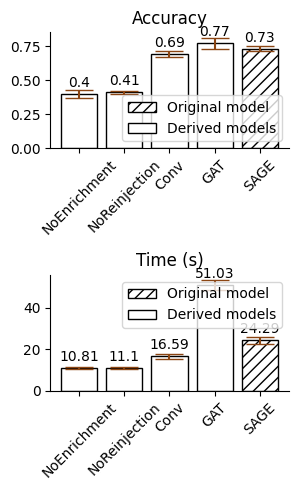

In [62]:
import matplotlib.pyplot as plt

x = np.arange(len(models))


def autolabel(rects, n):
    for rect in rects:
        height = rect.get_height()
        axs[n].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# Plotting the bar plots
width = 0.8  # width of the bars
fig, axs = plt.subplots(2, 1, figsize=(3, 5))

rects_accuracy = []
rects_accuracy.append(axs[0].bar(x, accuracy, width, yerr = accuracy_std, label = 'Accuracy',color = 'white', 
                                 edgecolor = 'black', capsize = 10, ecolor = 'saddlebrown'))
rects_accuracy[0][-1].set_hatch('///')
autolabel(rects_accuracy[0], 0)
axs[0].set_title('Accuracy')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation = 45)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].title.set_position([0.5, .05])
axs[0].legend([rects_accuracy[0][-1], rects_accuracy[0][0]],['Original model', 'Derived models'])

rects_time = []
rects_time.append(axs[1].bar(x, time, width, yerr = time_std, label = 'Time', color = 'white', 
                                 edgecolor = 'black', capsize = 10, ecolor = 'saddlebrown'))

rects_time[0][-1].set_hatch('///')
autolabel(rects_time[0], 1)
axs[1].set_title('Time (s)')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation = 45)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].title.set_position([0.5, .05])
axs[1].legend([rects_time[0][-1], rects_time[0][0]],['Original model', 'Derived models'])
'''
rects_precision = []
rects_precision.append(axs[1].bar(x, precision, width, yerr = precision_std, label = 'Precision', color = 'white', 
                                 edgecolor = 'black', capsize = 10, ecolor = 'saddlebrown'))
rects_precision[0][-1].set_hatch('///')
autolabel(rects_precision[0], 1)
axs[1].set_title('Precision')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation = 45)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].title.set_position([0.5, .05])
axs[1].legend([rects_precision[0][-1], rects_precision[0][0]],['Original model', 'Derived models'])


rects_f1 = []
rects_f1.append(axs[2].bar(x, f1, width, yerr = f1_std, label = 'F1', color = 'white', 
                                 edgecolor = 'black', capsize = 10, ecolor = 'saddlebrown'))
rects_f1[0][-1].set_hatch('///')
autolabel(rects_f1[0], 2)
axs[2].set_title('F1')
axs[2].set_xticks(x)
axs[2].set_xticklabels(models, rotation = 45)
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].title.set_position([0.5, .05])
axs[2].legend([rects_f1[0][-1], rects_f1[0][0]],['Original model', 'Derived models'])


rects_recall = []
rects_recall.append(axs[3].bar(x, recall, width, yerr = recall_std, label = 'Recall', color = 'white', 
                                 edgecolor = 'black', capsize = 10, ecolor = 'saddlebrown'))
rects_recall[0][-1].set_hatch('///')
autolabel(rects_recall[0], 3)
axs[3].set_title('Recall')
axs[3].set_xticks(x)
axs[3].set_xticklabels(models, rotation = 45)
axs[3].spines['top'].set_visible(False)
axs[3].spines['right'].set_visible(False)
axs[3].title.set_position([0.5, .05])  # Adjust the position of title for subplot 1
axs[3].legend([rects_recall[0][-1], rects_recall[0][0]],['Original model', 'Derived models'])
'''




plt.tight_layout()
plt.show()

In [82]:
df_ModelNoReinjection['Model'] = 'NoReinjection'
df_ModelNoEnrichment['Model'] = 'NoEnrichment'
df_ModelConv['Model'] = 'Conv'
df_ModelGAT['Model'] = 'GAT'
df_ModelSAGE['Model'] = 'SAGE'

df_ModelNoReinjection['Data'] = main_publisher
df_ModelNoEnrichment['Data'] = main_publisher
df_ModelConv['Data'] = main_publisher
df_ModelGAT['Data'] = main_publisher
df_ModelSAGE['Data'] = main_publisher

In [83]:
df_ModelsAll = pd.concat([df_ModelNoReinjection, df_ModelNoEnrichment,
                          df_ModelConv, df_ModelGAT, df_ModelSAGE])
df_ModelsAll.to_csv(f'./ablation_results_{main_publisher}.csv', index = False)

In [60]:
main_publisher = 'Khan'
df_ModelsAll = pd.read_csv(f'./ablation_results_{main_publisher}.csv')
df_ModelNoReinjection = df_ModelsAll[df_ModelsAll['Model']=='NoReinjection']
df_ModelNoEnrichment = df_ModelsAll[df_ModelsAll['Model']=='NoEnrichment']
df_ModelConv = df_ModelsAll[df_ModelsAll['Model']=='Conv']
df_ModelGAT = df_ModelsAll[df_ModelsAll['Model']=='GAT']
df_ModelSAGE = df_ModelsAll[df_ModelsAll['Model']=='SAGE']